# sim_06_PINN — Physics-Informed Neural Network (PINN) bazujący na modelu PDE

Cel: zbudować i przetestować model **PINN**, który aproksymuje rozwiązanie 1D PDE (ground truth) z `sim_04_node.ipynb` (eksperyment2/4), a następnie porównać:
- **PDE** (symulacja numeryczna, ground truth),
- **ODE** (model zredukowany, baseline),
- **PINN** (model uczony z ograniczeniem fizycznym PDE).

Wizualizacja jest generowana w stylu spójnym z `sim_04_node.ipynb` (ciemne tło + kolory linii), z zaznaczeniem strefy treningowej **10–25 s**.

Pliki wynikowe są zapisywane do:
`DEFAULT_OUTPUT_DIR = Path('../figures/sim_06')`


In [1]:
# Plot styling (applies globally to all matplotlib figures in this notebook)
import matplotlib as mpl

BG = "#252629"

mpl.rcParams.update({
    "figure.facecolor": BG,
    "axes.facecolor": BG,
    "savefig.facecolor": BG,
    "text.color": "white",
    "axes.labelcolor": "white",
    "axes.edgecolor": "white",
    "axes.titlecolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "legend.edgecolor": "white",
    "grid.color": "white",
})

# Optional: make saved figures keep the background even if code uses transparent saves
mpl.rcParams["savefig.transparent"] = False



In [2]:
# ==========================================
# Importy + ustawienia wyjścia
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path

# Determinizm (w granicach możliwości CPU)
np.random.seed(42)
torch.manual_seed(42)

DEFAULT_OUTPUT_DIR = Path('../figures/sim_06')
DEFAULT_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output directory set to: {DEFAULT_OUTPUT_DIR.resolve()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Output directory set to: /Users/igorzakrocki/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/AGH/IDS_9/Informatyka Systemów Złożonych/CS_radiotherapy_project/figures/sim_06
Using device: cpu


In [ ]:
# ============================================================
# 1. PARAMETRY I FUNKCJE Z EXPERIMENT2.PY (wg sim_04_node.ipynb)
#    (PDE 1D w przestrzeni + logistyka + radioterapia)
# ============================================================

# Global spatial / temporal setup
L = 1.0
N = 101
x_grid = np.linspace(0.0, L, N)
dx = x_grid[1] - x_grid[0]

T_END = 35.0
dt = 0.01
NSTEPS = int(T_END / dt)

# Base biophysical parameters
D_base = 0.001
rho_base = 0.25
beta_base = 0.6
K = 1.0

# Hypoxia profile (zgodny z sim_04_node)
def hypoxia_profile(x):
    return 0.4 + 0.6 * np.exp(-((x - 0.5 * L) / 0.5) ** 2)

H_vec = hypoxia_profile(x_grid)

# Temporal dose schedule (zgodny z sim_04_node)
def dose_rate_time(t):
    dose_amp = 4.0
    fraction_duration = 0.2
    course_starts = [5.0, 15.0, 25.0]

    for cs in course_starts:
        for n in range(5):
            t_start = cs + n * 1.0
            t_end = t_start + fraction_duration
            if t_start <= t <= t_end:
                return dose_amp
    return 0.0

# --- parametryzacja IC i profilu dawki (żeby PINN był warunkowy po scenariuszu) ---
# Zgodne z initial_condition() i dose_profile() z sim_04_node.
def ic_params(kind: str):
    # Zwraca: (bias, a1, mu1, s1, a2, mu2, s2)
    if kind == "left_peak":
        return (0.1, 0.5, 0.2, 0.1, 0.0, 0.0, 0.1)
    if kind == "center_peak":
        return (0.1, 0.5, 0.5, 0.1, 0.0, 0.0, 0.1)
    if kind == "right_peak":
        return (0.1, 0.5, 0.8, 0.1, 0.0, 0.0, 0.1)
    if kind == "double_peak":
        return (0.05, 0.35, 0.25, 0.07, 0.35, 0.75, 0.07)
    # fallback
    return (0.2, 0.0, 0.5, 0.1, 0.0, 0.0, 0.1)

def dose_params(kind: str):
    # Zwraca: (bias, amp, mu, sigma)
    # Uniform: W_raw = 1
    if kind == "uniform":
        return (1.0, 0.0, 0.5, 0.1)
    if kind == "left_focus":
        return (0.2, 0.8, 0.2, 0.1)
    if kind == "center_focus":
        return (0.2, 0.8, 0.5, 0.1)
    if kind == "right_focus":
        return (0.2, 0.8, 0.8, 0.1)
    return (1.0, 0.0, 0.5, 0.1)

def initial_condition(kind, x):
    # Kopia logiki z sim_04_node (wraz z normalizacją)
    if kind == "left_peak":
        u0 = 0.1 + 0.5 * np.exp(-((x - 0.2) / 0.1) ** 2)
    elif kind == "center_peak":
        u0 = 0.1 + 0.5 * np.exp(-((x - 0.5) / 0.1) ** 2)
    elif kind == "right_peak":
        u0 = 0.1 + 0.5 * np.exp(-((x - 0.8) / 0.1) ** 2)
    elif kind == "double_peak":
        u0 = (0.05 + 0.35 * np.exp(-((x - 0.25) / 0.07) ** 2)
                   + 0.35 * np.exp(-((x - 0.75) / 0.07) ** 2))
    else:
        u0 = 0.2 * np.ones_like(x)

    u = np.clip(u0, 0.0, 1.0)
    return u / np.sum(u) * 20

def dose_profile(kind, x):
    # Kopia logiki z sim_04_node (wraz z normalizacją)
    if kind == "uniform":
        W = np.ones_like(x)
    elif kind == "left_focus":
        W = 0.2 + 0.8 * np.exp(-((x - 0.2) / 0.1) ** 2)
    elif kind == "center_focus":
        W = 0.2 + 0.8 * np.exp(-((x - 0.5) / 0.1) ** 2)
    elif kind == "right_focus":
        W = 0.2 + 0.8 * np.exp(-((x - 0.8) / 0.1) ** 2)
    else:
        W = np.ones_like(x)

    W = W / np.sum(W)
    return W * 200

# ============================================================
# 2. MODELE: PDE (Ground Truth) + ODE (Baseline)
# ============================================================

def run_pde_simulation_full(D, rho, beta, u0, W, return_u_history=True):
    """Symulacja PDE 1D (jak w sim_04_node), opcjonalnie zwraca historię u(t,x)."""
    u = u0.copy()
    times = np.zeros(NSTEPS + 1)
    mass_pde = np.zeros(NSTEPS + 1)

    u_hist = None
    if return_u_history:
        u_hist = np.zeros((NSTEPS + 1, N), dtype=np.float32)
        u_hist[0] = u.astype(np.float32)

    times[0] = 0.0
    mass_pde[0] = np.trapz(u, x_grid)

    for n in range(1, NSTEPS + 1):
        t = n * dt

        # Laplacjan z warunkami Neumanna (odbijające)
        u_xx = np.zeros_like(u)
        u_xx[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
        u_xx[0] = 2 * (u[1] - u[0]) / dx**2
        u_xx[-1] = 2 * (u[-2] - u[-1]) / dx**2

        r_t = dose_rate_time(t)
        R_xt = r_t * W
        kill_term = beta * R_xt * H_vec * u

        du_dt = D * u_xx + rho * u * (1.0 - u / K) - kill_term
        u = u + dt * du_dt
        u = np.clip(u, 0.0, 1.0)

        times[n] = t
        mass_pde[n] = np.trapz(u, x_grid)

        if return_u_history:
            u_hist[n] = u.astype(np.float32)

    if return_u_history:
        return times, mass_pde, u_hist
    return times, mass_pde

def physics_ode_derivative(U_mass, r_t, rho, beta, WH_mean):
    """Pochodna ODE (baseline) zgodna z sim_04_node."""
    U = U_mass  # L=1.0, więc Mass == Mean
    growth = rho * U * (1.0 - U / K)
    kill = beta * r_t * WH_mean * U
    return growth - kill

def run_pure_ode_simulation(u0, rho, beta, W):
    times = np.linspace(0, T_END, NSTEPS + 1)
    mass_ode = np.zeros(NSTEPS + 1)
    current_mass = np.trapz(u0, x_grid)
    mass_ode[0] = current_mass
    WH_mean = np.mean(W * H_vec)

    for n in range(NSTEPS):
        t = times[n]
        r_t = dose_rate_time(t)
        d_phys = physics_ode_derivative(current_mass, r_t, rho, beta, WH_mean)
        current_mass += dt * d_phys
        current_mass = max(current_mass, 0.0)
        mass_ode[n+1] = current_mass
    return times, mass_ode

# Zakres treningowy (jak w sim_04_node)
T_TRAIN_START = 0
T_TRAIN_END = 1.0


In [22]:
# ============================================================
# 3. Generowanie danych (PDE) dla scenariuszy 4x4 (jak w sim_04_node)
#    Dane służą do:
#    - losowania punktów nadzorowanych (u(t,x) w strefie treningowej),
#    - warunków początkowych,
#    - ewaluacji masy (PDE ground truth).
# ============================================================

ic_kinds = ["left_peak", "center_peak", "right_peak", "double_peak"]
dose_kinds = ["uniform", "left_focus", "center_focus", "right_focus"]

rho_factors = [0.7, 0.9, 1.1, 1.3]
beta_factors = [0.6, 0.8, 1.0, 1.2]

def compute_W_scale_np(dose_p, x_grid):
    """Skalowanie tak, aby W = W_raw/sum(W_raw)*200 (zgodne z dose_profile())."""
    dose_bias, dose_amp, dose_mu, dose_s = dose_p
    W_raw = dose_bias + dose_amp * np.exp(-((x_grid - dose_mu) / dose_s) ** 2)
    return float(200.0 / np.sum(W_raw))

scenarios = []
print("Generuję przebiegi PDE dla 16 scenariuszy (CPU)...")

for i, ic_name in enumerate(ic_kinds):
    for j, dose_name in enumerate(dose_kinds):
        rho = rho_base * rho_factors[i]
        beta = beta_base * beta_factors[j]
        u0 = initial_condition(ic_name, x_grid)
        W = dose_profile(dose_name, x_grid)

        ts, mass_pde, u_hist = run_pde_simulation_full(D_base, rho, beta, u0, W, return_u_history=True)

        train_mask = (ts >= T_TRAIN_START) & (ts < T_TRAIN_END)
        train_time_indices = np.where(train_mask)[0]

        ic_p = ic_params(ic_name)
        dose_p = dose_params(dose_name)
        W_scale = compute_W_scale_np(dose_p, x_grid)

        scenarios.append({
            "ic_name": ic_name,
            "dose_name": dose_name,
            "rho": float(rho),
            "beta": float(beta),
            "u0": u0.astype(np.float32),
            "W": W.astype(np.float32),
            "ts": ts.astype(np.float32),
            "mass_pde": mass_pde.astype(np.float32),
            "u_hist": u_hist,  # (T,N)
            "train_time_indices": train_time_indices.astype(np.int32),
            "ic_params": ic_p,
            "dose_params": dose_p,
            "W_scale": W_scale,
        })

print("Liczba scenariuszy:", len(scenarios))
print("Przykład:", scenarios[0]["ic_name"], scenarios[0]["dose_name"])


Generuję przebiegi PDE dla 16 scenariuszy (CPU)...


/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3758/3592047797.py:119: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_pde[0] = np.trapz(u, x_grid)
/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3758/3592047797.py:139: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_pde[n] = np.trapz(u, x_grid)


Liczba scenariuszy: 16
Przykład: left_peak uniform


In [23]:
# ============================================================
# 4. PINN: definicja modelu + funkcje fizyczne (Torch)
# ============================================================

def dose_rate_torch(t: torch.Tensor) -> torch.Tensor:
    """Torch-owa wersja dose_rate_time(t) (piecewise)."""
    dose_amp = 4.0
    fraction_duration = 0.2
    course_starts = [5.0, 15.0, 25.0]
    r = torch.zeros_like(t)

    for cs in course_starts:
        for n in range(5):
            t_start = cs + n * 1.0
            t_end = t_start + fraction_duration
            r = torch.where((t >= t_start) & (t <= t_end), torch.as_tensor(dose_amp, device=t.device, dtype=t.dtype), r)
    return r

def hypoxia_torch(x: torch.Tensor) -> torch.Tensor:
    return 0.4 + 0.6 * torch.exp(-((x - 0.5 * L) / 0.5) ** 2)

def dose_profile_torch(x: torch.Tensor, dose_bias, dose_amp, dose_mu, dose_sigma, W_scale) -> torch.Tensor:
    # W_raw = bias + amp * exp(-((x-mu)/sigma)^2)
    W_raw = dose_bias + dose_amp * torch.exp(-((x - dose_mu) / dose_sigma) ** 2)
    return W_raw * W_scale

class PINN(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 64, depth: int = 4):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_dim, hidden))
        layers.append(nn.Tanh())
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, inp: torch.Tensor) -> torch.Tensor:
        # Skala wyjścia do [0,1] (zgodne z clippingiem w PDE)
        return torch.sigmoid(self.net(inp))

# Wejście: [t_norm, x_norm, rho_norm, beta_norm,
#           ic_bias, ic_a1, ic_mu1_norm, ic_s1_norm, ic_a2, ic_mu2_norm, ic_s2_norm,
#           dose_bias, dose_amp, dose_mu_norm, dose_sigma_norm, W_scale_norm]
IN_DIM = 16
pinn = PINN(IN_DIM, hidden=64, depth=4).to(device)

def pack_inputs(t, x, rho, beta, ic_p, dose_p, W_scale):
    """Skleja wejście i wykonuje lekką normalizację."""
    # t, x: (B,)
    t_norm = 2.0 * (t / T_END) - 1.0
    x_norm = 2.0 * (x / L) - 1.0

    rho_norm = rho / rho_base
    beta_norm = beta / beta_base

    ic_bias, ic_a1, ic_mu1, ic_s1, ic_a2, ic_mu2, ic_s2 = ic_p
    dose_bias, dose_amp, dose_mu, dose_s = dose_p

    ic_mu1_norm = 2.0 * (ic_mu1 / L) - 1.0
    ic_mu2_norm = 2.0 * (ic_mu2 / L) - 1.0
    ic_s1_norm = ic_s1 / 0.1
    ic_s2_norm = ic_s2 / 0.1

    dose_mu_norm = 2.0 * (dose_mu / L) - 1.0
    dose_s_norm = dose_s / 0.1

    W_scale_norm = W_scale / 2.0  # ok. ~1

    # broadcast stałych do batcha
    B = t.shape[0]
    def bcast(v):
        return torch.full((B,), float(v), device=device, dtype=torch.float32)

    inp = torch.stack([
        t_norm, x_norm, rho_norm, beta_norm,
        bcast(ic_bias), bcast(ic_a1), bcast(ic_mu1_norm), bcast(ic_s1_norm),
        bcast(ic_a2), bcast(ic_mu2_norm), bcast(ic_s2_norm),
        bcast(dose_bias), bcast(dose_amp), bcast(dose_mu_norm), bcast(dose_s_norm),
        bcast(W_scale_norm),
    ], dim=1)
    return inp

def pde_residual(pinn: nn.Module, t: torch.Tensor, x: torch.Tensor, rho: float, beta: float, ic_p, dose_p, W_scale: float) -> torch.Tensor:
    """Resztka PDE: u_t - (D u_xx + rho u(1-u) - beta r(t) W(x) H(x) u)"""
    t = t.clone().detach().requires_grad_(True)
    x = x.clone().detach().requires_grad_(True)

    inp = pack_inputs(t, x, torch.full_like(t, rho), torch.full_like(t, beta), ic_p, dose_p, W_scale)
    u = pinn(inp).squeeze(1)  # (B,)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    r_t = dose_rate_torch(t)
    H = hypoxia_torch(x)

    dose_bias, dose_amp, dose_mu, dose_s = dose_p
    W = dose_profile_torch(x, float(dose_bias), float(dose_amp), float(dose_mu), float(dose_s), float(W_scale))

    # PDE
    rhs = D_base * u_xx + rho * u * (1.0 - u / K) - beta * r_t * W * H * u
    return u_t - rhs

print("PINN ready. #params:", sum(p.numel() for p in pinn.parameters()))


PINN ready. #params: 13633


Iter     1/2000 | loss=2.2759e+00 | data=9.5410e-02 | phys=4.4531e-01 | bc=5.8329e-06 | ic=8.7647e-02
Iter   200/2000 | loss=4.8475e-01 | data=1.6706e-02 | phys=3.4092e-02 | bc=4.6070e-04 | ic=2.8314e-02
Iter   400/2000 | loss=3.8478e-01 | data=1.4622e-02 | phys=2.2836e-02 | bc=6.5275e-03 | ic=2.0920e-02
Iter   600/2000 | loss=2.9135e-01 | data=1.1486e-02 | phys=3.3733e-02 | bc=1.1472e-02 | ic=1.3128e-02
Iter   800/2000 | loss=2.1082e-01 | data=1.2935e-02 | phys=2.6207e-02 | bc=7.9475e-03 | ic=4.7307e-03
Iter  1000/2000 | loss=2.0800e-01 | data=1.2495e-02 | phys=2.2838e-02 | bc=5.3996e-03 | ic=5.4811e-03
Iter  1200/2000 | loss=1.8397e-01 | data=1.2220e-02 | phys=2.0272e-02 | bc=4.6022e-03 | ic=3.6892e-03
Iter  1400/2000 | loss=1.9221e-01 | data=1.2358e-02 | phys=1.5375e-02 | bc=4.2614e-03 | ic=4.8986e-03
Iter  1600/2000 | loss=1.6544e-01 | data=1.0818e-02 | phys=1.6089e-02 | bc=6.9387e-03 | ic=3.4240e-03
Iter  1800/2000 | loss=1.7840e-01 | data=1.2690e-02 | phys=1.7406e-02 | bc=4.8304e

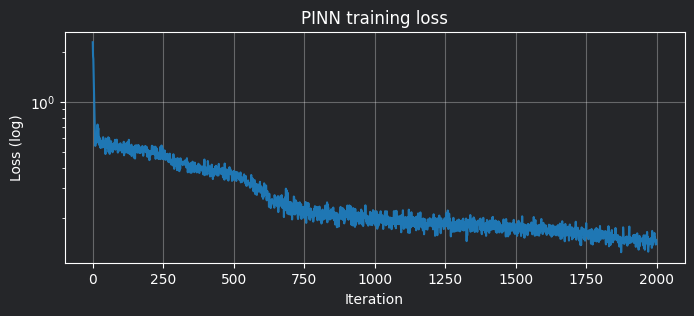

In [24]:
# ============================================================
# 5. Trening PINN (online sampling, z wektoryzacją po scenariuszach)
# ============================================================

# Wagi składników straty
W_DATA = 10.0
W_PHYS = 1.0
W_BC   = 1.0
W_IC   = 10.0

# Batch sizes (dostosuj w razie potrzeby)
B_DATA = 1024     # supervised points u(t,x) w train-zone
B_PHYS = 1024     # collocation points dla reszty PDE
B_BC   = 256      # boundary points (Neumann)
B_IC   = 512     # initial condition points

N_ITERS = 2000    # w razie potrzeby zwiększ (np. 5000+)
LR = 1e-3

optimizer = optim.Adam(pinn.parameters(), lr=LR)

n_scen = len(scenarios)

def sample_supervised_batch(B: int):
    scen_idx = np.random.randint(0, n_scen, size=B)
    t = np.empty(B, dtype=np.float32)
    x = np.empty(B, dtype=np.float32)
    u = np.empty(B, dtype=np.float32)

    for k, si in enumerate(scen_idx):
        sc = scenarios[int(si)]
        ti = int(np.random.choice(sc["train_time_indices"]))
        xi = int(np.random.randint(0, N))
        t[k] = sc["ts"][ti]
        x[k] = x_grid[xi]
        u[k] = sc["u_hist"][ti, xi]

    return (
        torch.tensor(t, dtype=torch.float32, device=device),
        torch.tensor(x, dtype=torch.float32, device=device),
        torch.tensor(u, dtype=torch.float32, device=device),
        scen_idx.astype(np.int32),
    )

def sample_physics_batch(B: int):
    scen_idx = np.random.randint(0, n_scen, size=B)
    t = np.random.uniform(T_TRAIN_START, T_TRAIN_END, size=B).astype(np.float32)
    x = np.random.uniform(0.0, L, size=B).astype(np.float32)
    return (
        torch.tensor(t, dtype=torch.float32, device=device),
        torch.tensor(x, dtype=torch.float32, device=device),
        scen_idx.astype(np.int32),
    )

def sample_bc_batch(B: int):
    scen_idx = np.random.randint(0, n_scen, size=B)
    t = np.random.uniform(T_TRAIN_START, T_TRAIN_END, size=B).astype(np.float32)
    x = np.zeros(B, dtype=np.float32)
    x[B//2:] = L
    return (
        torch.tensor(t, dtype=torch.float32, device=device),
        torch.tensor(x, dtype=torch.float32, device=device),
        scen_idx.astype(np.int32),
    )

def sample_ic_batch(B: int):
    scen_idx = np.random.randint(0, n_scen, size=B)
    t = np.zeros(B, dtype=np.float32)
    x = np.random.uniform(0.0, L, size=B).astype(np.float32)
    return (
        torch.tensor(t, dtype=torch.float32, device=device),
        torch.tensor(x, dtype=torch.float32, device=device),
        scen_idx.astype(np.int32),
    )

def scenario_meta(si: int):
    sc = scenarios[int(si)]
    return sc["rho"], sc["beta"], sc["ic_params"], sc["dose_params"], sc["W_scale"]

loss_history = []

pinn.train()
for it in range(1, N_ITERS + 1):
    optimizer.zero_grad()

    # ----------------------------
    # 1) supervised (u(t,x) w strefie treningowej)
    # ----------------------------
    t_d, x_d, u_tgt, meta_d = sample_supervised_batch(B_DATA)
    u_pred = torch.empty_like(u_tgt)

    for si in np.unique(meta_d):
        mask = (meta_d == si)
        idx = np.where(mask)[0]
        rho, beta, ic_p, dose_p, W_scale = scenario_meta(int(si))
        inp = pack_inputs(t_d[idx], x_d[idx],
                          torch.full((len(idx),), rho, device=device),
                          torch.full((len(idx),), beta, device=device),
                          ic_p, dose_p, W_scale)
        u_pred[idx] = pinn(inp).squeeze(1)

    loss_data = torch.mean((u_pred - u_tgt) ** 2)

    # ----------------------------
    # 2) physics residual w strefie treningowej
    # ----------------------------
    t_p, x_p, meta_p = sample_physics_batch(B_PHYS)
    res_all = torch.empty((B_PHYS,), device=device, dtype=torch.float32)

    for si in np.unique(meta_p):
        mask = (meta_p == si)
        idx = np.where(mask)[0]
        rho, beta, ic_p, dose_p, W_scale = scenario_meta(int(si))
        res = pde_residual(pinn, t_p[idx], x_p[idx], rho, beta, ic_p, dose_p, W_scale).squeeze()
        res_all[idx] = res

    loss_phys = torch.mean(res_all ** 2)

    # ----------------------------
    # 3) BC: Neumann u_x(t,0)=0 oraz u_x(t,1)=0
    # ----------------------------
    t_b, x_b, meta_b = sample_bc_batch(B_BC)
    ux_all = torch.empty((B_BC,), device=device, dtype=torch.float32)

    for si in np.unique(meta_b):
        mask = (meta_b == si)
        idx = np.where(mask)[0]
        rho, beta, ic_p, dose_p, W_scale = scenario_meta(int(si))

        t1 = t_b[idx].clone().detach().requires_grad_(True)
        x1 = x_b[idx].clone().detach().requires_grad_(True)

        inp = pack_inputs(t1, x1,
                          torch.full((len(idx),), rho, device=device),
                          torch.full((len(idx),), beta, device=device),
                          ic_p, dose_p, W_scale)
        u = pinn(inp).squeeze(1)
        u_x = torch.autograd.grad(u, x1, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ux_all[idx] = u_x

    loss_bc = torch.mean(ux_all ** 2)

    # ----------------------------
    # 4) IC: u(0,x)=u0(x)
    # ----------------------------
    t_i, x_i, meta_i = sample_ic_batch(B_IC)
    ui_pred = torch.empty((B_IC,), device=device, dtype=torch.float32)
    ui_tgt = torch.empty((B_IC,), device=device, dtype=torch.float32)

    for si in np.unique(meta_i):
        mask = (meta_i == si)
        idx = np.where(mask)[0]
        sc = scenarios[int(si)]
        rho, beta, ic_p, dose_p, W_scale = scenario_meta(int(si))

        # target u0 przez interpolację na siatce (numpy -> torch)
        u0_vals = np.interp(x_i[idx].detach().cpu().numpy(), x_grid, sc["u0"]).astype(np.float32)
        ui_tgt[idx] = torch.tensor(u0_vals, device=device)

        inp = pack_inputs(t_i[idx], x_i[idx],
                          torch.full((len(idx),), rho, device=device),
                          torch.full((len(idx),), beta, device=device),
                          ic_p, dose_p, W_scale)
        ui_pred[idx] = pinn(inp).squeeze(1)

    loss_ic = torch.mean((ui_pred - ui_tgt) ** 2)

    # ----------------------------
    # total
    # ----------------------------
    loss = W_DATA * loss_data + W_PHYS * loss_phys + W_BC * loss_bc + W_IC * loss_ic
    loss.backward()
    optimizer.step()

    loss_history.append(float(loss.detach().cpu()))
    if it % 200 == 0 or it == 1:
        print(f"Iter {it:5d}/{N_ITERS} | loss={loss.item():.4e} | data={loss_data.item():.4e} | phys={loss_phys.item():.4e} | bc={loss_bc.item():.4e} | ic={loss_ic.item():.4e}")

print("Trening zakończony.")

# (opcjonalnie) szybki wykres spadku straty
plt.figure(figsize=(8, 3))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Loss (log)")
plt.title("PINN training loss")
plt.grid(True, alpha=0.3)
plt.show()


/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3758/3592047797.py:119: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_pde[0] = np.trapz(u, x_grid)
/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3758/3592047797.py:139: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_pde[n] = np.trapz(u, x_grid)
/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3758/3592047797.py:158: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  current_mass = np.trapz(u0, x_grid)
/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3758/919769844.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass = np.trap

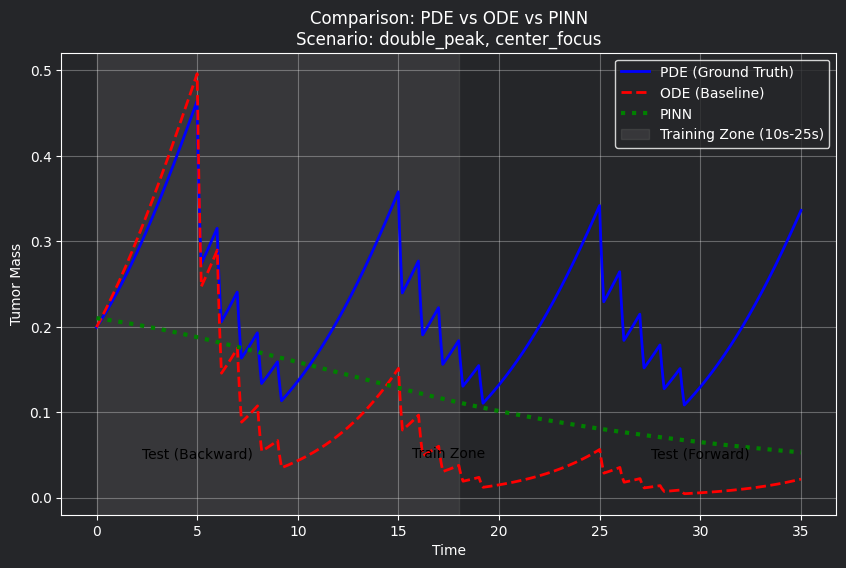

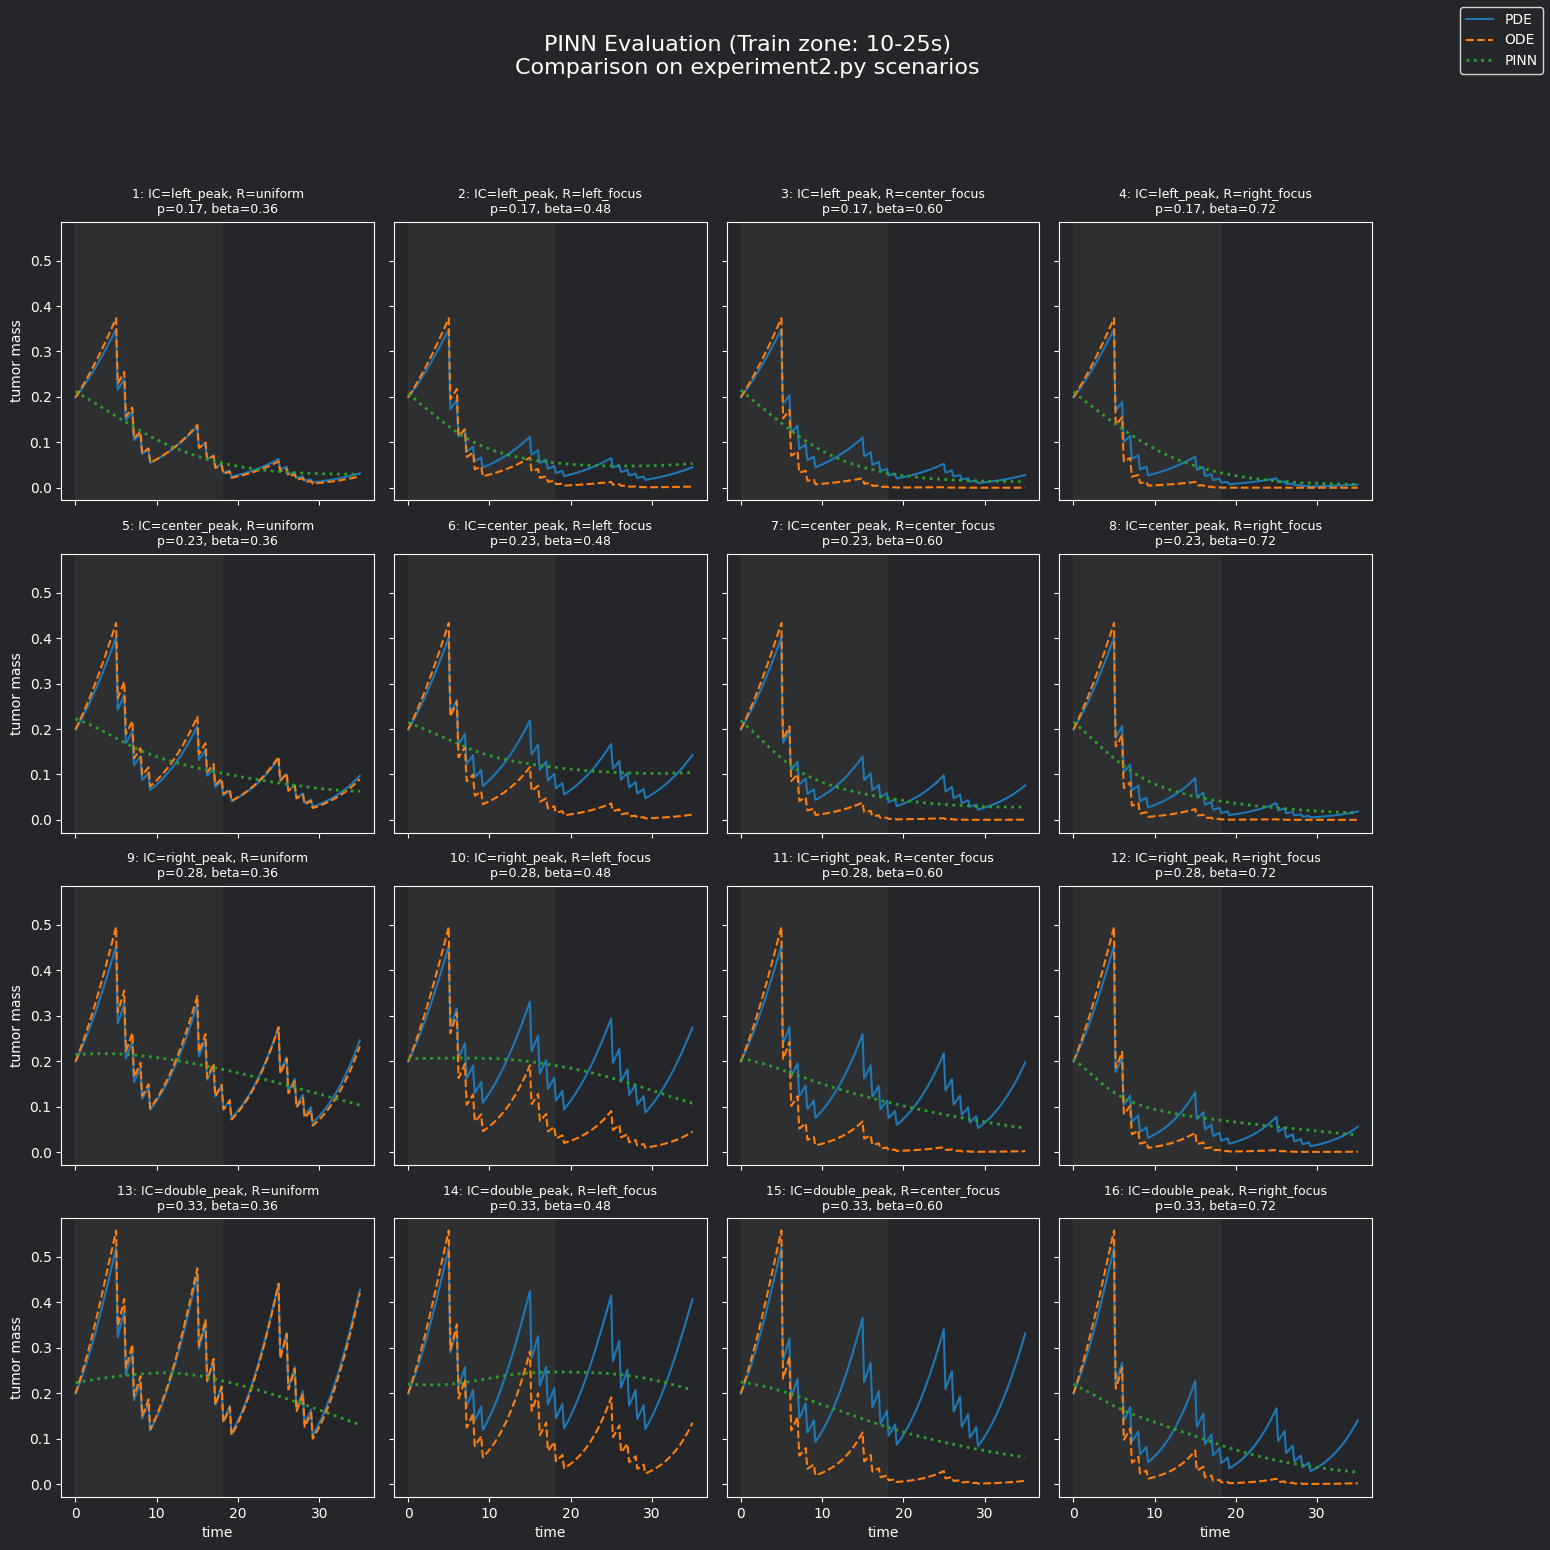

Gotowe. Wygenerowano pliki w: ../figures/sim_06


In [25]:
# ============================================================
# 6. Ewaluacja: predykcja masy z PINN + wykresy (jak w sim_04_node)
# ============================================================

def compute_W_scale_np(dose_p, x_grid):
    dose_bias, dose_amp, dose_mu, dose_s = dose_p
    W_raw = dose_bias + dose_amp * np.exp(-((x_grid - dose_mu) / dose_s) ** 2)
    return float(200.0 / np.sum(W_raw))

@torch.no_grad()
def predict_mass_series(pinn: nn.Module, scenario: dict, ts: np.ndarray, x: np.ndarray, batch_size: int = 65536) -> np.ndarray:
    pinn.eval()
    rho = scenario["rho"]
    beta = scenario["beta"]
    ic_p = scenario["ic_params"]
    dose_p = scenario["dose_params"]
    W_scale = scenario["W_scale"]

    T = len(ts)
    X = len(x)
    t_rep = np.repeat(ts, X).astype(np.float32)
    x_tile = np.tile(x, T).astype(np.float32)

    t_t = torch.tensor(t_rep, device=device)
    x_t = torch.tensor(x_tile, device=device)

    u_pred = torch.empty((T * X,), device=device, dtype=torch.float32)

    start = 0
    while start < T * X:
        end = min(start + batch_size, T * X)
        inp = pack_inputs(t_t[start:end], x_t[start:end],
                          torch.full((end-start,), rho, device=device),
                          torch.full((end-start,), beta, device=device),
                          ic_p, dose_p, W_scale)
        u_pred[start:end] = pinn(inp).squeeze(1)
        start = end

    u_pred = u_pred.reshape(T, X).cpu().numpy()
    mass = np.trapz(u_pred, x, axis=1)
    return mass

# --- Wykres 1: szczegółowe porównanie dla jednego scenariusza (jak w sim_04_node) ---
test_ic = "double_peak"
test_dose = "center_focus"
rho_test = rho_base * 1.1
beta_test = beta_base * 0.8

u0_test = initial_condition(test_ic, x_grid)
W_test = dose_profile(test_dose, x_grid)

ts, m_pde = run_pde_simulation_full(D_base, rho_test, beta_test, u0_test, W_test, return_u_history=False)

# ODE baseline
_, m_ode = run_pure_ode_simulation(u0_test, rho_test, beta_test, W_test)

scenario_test = {
    "rho": float(rho_test),
    "beta": float(beta_test),
    "ic_params": ic_params(test_ic),
    "dose_params": dose_params(test_dose),
    "W_scale": compute_W_scale_np(dose_params(test_dose), x_grid),
}
m_pinn = predict_mass_series(pinn, scenario_test, ts, x_grid)

plt.figure(figsize=(10, 6))
plt.plot(ts, m_pde, 'b-', linewidth=2, label='PDE (Ground Truth)')
plt.plot(ts, m_ode, 'r--', linewidth=2, label='ODE (Baseline)')
plt.plot(ts, m_pinn, 'g:', linewidth=3, label='PINN')

plt.axvspan(T_TRAIN_START, T_TRAIN_END, color='gray', alpha=0.2, label='Training Zone (10s-25s)')

plt.text(5, max(m_pde)*0.1, "Test (Backward)", ha='center', color='black')
plt.text(17.5, max(m_pde)*0.1, "Train Zone", ha='center', color='black')
plt.text(30, max(m_pde)*0.1, "Test (Forward)", ha='center', color='black')

plt.xlabel("Time")
plt.ylabel("Tumor Mass")
plt.title(f"Comparison: PDE vs ODE vs PINN\nScenario: {test_ic}, {test_dose}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(DEFAULT_OUTPUT_DIR / "sim06_comparison.png")
plt.show()

# --- Wykres 2: Grid 4x4 (zgodny z sim_04_node) ---
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)

scenario_idx = 0
for i, ic_name in enumerate(ic_kinds):
    for j, dose_name in enumerate(dose_kinds):
        scenario_idx += 1
        rho = rho_base * rho_factors[i]
        beta = beta_base * beta_factors[j]

        u0 = initial_condition(ic_name, x_grid)
        W = dose_profile(dose_name, x_grid)

        ts, m_pde = run_pde_simulation_full(D_base, rho, beta, u0, W, return_u_history=False)
        _, m_ode = run_pure_ode_simulation(u0, rho, beta, W)

        scenario_eval = {
            "rho": float(rho),
            "beta": float(beta),
            "ic_params": ic_params(ic_name),
            "dose_params": dose_params(dose_name),
            "W_scale": compute_W_scale_np(dose_params(dose_name), x_grid),
        }
        m_pinn = predict_mass_series(pinn, scenario_eval, ts, x_grid)

        ax = axes[i, j]
        ax.plot(ts, m_pde, label="PDE")
        ax.plot(ts, m_ode, "--", label="ODE")
        ax.plot(ts, m_pinn, ":", linewidth=2, label="PINN")

        ax.axvspan(T_TRAIN_START, T_TRAIN_END, color='gray', alpha=0.1)

        ax.set_title(
            f"{scenario_idx}: IC={ic_name}, R={dose_name}\n"
            f"p={rho:.2f}, beta={beta:.2f}", fontsize=9
        )
        if i == 3:
            ax.set_xlabel("time")
        if j == 0:
            ax.set_ylabel("tumor mass")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.suptitle(
    "PINN Evaluation (Train zone: 10-25s)\n"
    "Comparison on experiment2.py scenarios",
    fontsize=16
)

fig.tight_layout(rect=[0.03, 0.03, 0.9, 0.93])
plt.savefig(DEFAULT_OUTPUT_DIR / "sim06_grid.png")
plt.show()

print("Gotowe. Wygenerowano pliki w:", DEFAULT_OUTPUT_DIR)


## Rozszerzenie: NODE + SuperNet (SuperNet zbudowany na bazie PINN)

W tej części:
- Trenujemy **NODE (Hybrid ODE + MLP)** identycznie jak w `sim_04_node` (uczenie różnicy względem ODE, target z **PDE** w train-zone 10–25s).
- Następnie tworzymy **SuperNet** jako większy, parametryczny model residual (różnica względem ODE), ale **targety pochodzą z PINN** (distillation / teacher-student).
- Na wykresach porównujemy: **PDE vs ODE vs NODE vs SuperNet**.


In [26]:
# ============================================================
# 7. NODE (Hybrid ODE + MLP) — jak w sim_04_node
# ============================================================
from torch.utils.data import TensorDataset, DataLoader

H_vec_np = hypoxia_profile(x_grid).astype(np.float32)

def compute_WH_mean_np(W: np.ndarray) -> float:
    return float(np.mean(W.astype(np.float32) * H_vec_np))

class ResidualMLP_NODE(nn.Module):
    def __init__(self):
        super().__init__()
        # Wejście: [Mass, r(t), rho, beta, WH_mean] -> 5 cech
        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, mass, r_t, rho, beta, wh_mean):
        x_in = torch.stack([mass, r_t, rho, beta, wh_mean], dim=1)
        return self.net(x_in)

print("Buduję zbiór treningowy dla NODE (target z PDE, train-zone 10–25s)...")

X_train = []
y_train = []

for sc in scenarios:
    ts = sc["ts"]
    m_pde = sc["mass_pde"]
    rho = sc["rho"]
    beta = sc["beta"]
    WH_mean = compute_WH_mean_np(sc["W"])

    # indeksy w strefie treningowej (bez ostatniego)
    idxs = sc["train_time_indices"]
    idxs = idxs[idxs < (len(ts)-1)]

    for idx in idxs:
        t_curr = float(ts[idx])
        m_curr = float(m_pde[idx])
        m_next_target = float(m_pde[idx+1])

        r_curr = float(dose_rate_time(t_curr))

        d_ode = float(physics_ode_derivative(m_curr, r_curr, rho, beta, WH_mean))
        m_next_ode = m_curr + dt * d_ode

        # target: residual w pochodnej
        mlp_target = (m_next_target - m_next_ode) / dt

        X_train.append([m_curr, r_curr, rho, beta, WH_mean])
        y_train.append([mlp_target])

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device).unsqueeze(1)

print("NODE samples:", X_train.shape[0])

node_model = ResidualMLP_NODE().to(device)
node_opt = optim.Adam(node_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

loader = DataLoader(TensorDataset(X_train, y_train), batch_size=512, shuffle=True)

print("Trenuję NODE...")
for epoch in range(300):
    node_model.train()
    total = 0.0
    for xb, yb in loader:
        node_opt.zero_grad()
        pred = node_model(xb[:,0], xb[:,1], xb[:,2], xb[:,3], xb[:,4])
        loss = loss_fn(pred, yb)
        loss.backward()
        node_opt.step()
        total += loss.item() * xb.shape[0]
    if (epoch+1) % 50 == 0:
        print(f"  epoch {epoch+1:4d} | loss={total / X_train.shape[0]:.6e}")

@torch.no_grad()
def run_node_simulation(node_model: nn.Module, sc: dict) -> np.ndarray:
    """Symulacja masy w czasie: ODE physics + residual (NODE)."""
    node_model.eval()
    ts = sc["ts"]
    rho = sc["rho"]
    beta = sc["beta"]
    WH_mean = compute_WH_mean_np(sc["W"])

    mass = np.zeros_like(ts, dtype=np.float32)
    current_mass = float(np.trapz(sc["u0"], x_grid))
    mass[0] = current_mass

    for n in range(len(ts)-1):
        t = float(ts[n])
        r_t = float(dose_rate_time(t))

        d_phys = float(physics_ode_derivative(current_mass, r_t, rho, beta, WH_mean))

        inp = torch.tensor([current_mass, r_t, rho, beta, WH_mean], device=device, dtype=torch.float32).unsqueeze(0)
        d_corr = float(node_model(inp[:,0], inp[:,1], inp[:,2], inp[:,3], inp[:,4]).item())

        current_mass = current_mass + dt * (d_phys + d_corr)
        current_mass = max(current_mass, 0.0)

        mass[n+1] = current_mass

    return mass


Buduję zbiór treningowy dla NODE (target z PDE, train-zone 10–25s)...
NODE samples: 28800
Trenuję NODE...


/Users/igorzakrocki/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/AGH/IDS_9/Informatyka Systemów Złożonych/CS_radiotherapy_project/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:626: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch   50 | loss=6.458242e-03
  epoch  100 | loss=6.459464e-03
  epoch  150 | loss=6.445283e-03
  epoch  200 | loss=6.442730e-03
  epoch  250 | loss=6.444152e-03
  epoch  300 | loss=6.441651e-03


In [27]:
# ============================================================
# 8. SuperNet — distylacja dynamiki z PINN (target z PINN, a nie z PDE)
#    Cel: większy model residual (więcej parametrów scenariusza), ale trenowany na przebiegach wygenerowanych przez PINN.
# ============================================================

print("Generuję przebiegi masy z PINN dla wszystkich scenariuszy (teacher)...")
for sc in scenarios:
    if "mass_pinn" not in sc:
        sc["mass_pinn"] = predict_mass_series(pinn, sc, sc["ts"], x_grid).astype(np.float32)

def supernet_feature_vector(t: float, mass: float, sc: dict, WH_mean: float) -> np.ndarray:
    """Znormalizowane cechy wejściowe (spójne z normalizacją w PINN)."""
    rho = sc["rho"]
    beta = sc["beta"]
    ic_p = sc["ic_params"]          # (7,)
    dose_p = sc["dose_params"]      # (4,)
    W_scale = sc["W_scale"]

    # zgodnie z pack_inputs / wcześniejszą normalizacją
    t_norm = 2.0 * (t / T_END) - 1.0
    r_norm = dose_rate_time(t) / 4.0

    rho_norm = rho / rho_base
    beta_norm = beta / beta_base

    ic_bias, ic_a1, ic_mu1, ic_s1, ic_a2, ic_mu2, ic_s2 = ic_p
    dose_bias, dose_amp, dose_mu, dose_s = dose_p

    ic_mu1_norm = 2.0 * (ic_mu1 / L) - 1.0
    ic_mu2_norm = 2.0 * (ic_mu2 / L) - 1.0
    ic_s1_norm  = ic_s1 / 0.1
    ic_s2_norm  = ic_s2 / 0.1

    dose_mu_norm = 2.0 * (dose_mu / L) - 1.0
    dose_s_norm  = dose_s / 0.1

    W_scale_norm = W_scale / 2.0

    feats = np.array([
        mass,
        r_norm,
        rho_norm,
        beta_norm,
        WH_mean,
        t_norm,
        ic_bias, ic_a1, ic_mu1_norm, ic_s1_norm, ic_a2, ic_mu2_norm, ic_s2_norm,
        dose_bias, dose_amp, dose_mu_norm, dose_s_norm,
        W_scale_norm
    ], dtype=np.float32)
    return feats

class SuperNetResidual(nn.Module):
    def __init__(self, in_dim: int = 18, hidden: int = 128, depth: int = 4):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

print("Buduję zbiór treningowy dla SuperNet (target z PINN, train-zone 10–25s)...")

X_sup = []
y_sup = []

for sc in scenarios:
    ts = sc["ts"]
    m_pinn = sc["mass_pinn"]
    rho = sc["rho"]
    beta = sc["beta"]
    WH_mean = compute_WH_mean_np(sc["W"])

    idxs = sc["train_time_indices"]
    idxs = idxs[idxs < (len(ts)-1)]

    for idx in idxs:
        t_curr = float(ts[idx])
        m_curr = float(m_pinn[idx])
        m_next_target = float(m_pinn[idx+1])

        r_curr = float(dose_rate_time(t_curr))

        d_ode = float(physics_ode_derivative(m_curr, r_curr, rho, beta, WH_mean))
        m_next_ode = m_curr + dt * d_ode
        mlp_target = (m_next_target - m_next_ode) / dt

        X_sup.append(supernet_feature_vector(t_curr, m_curr, sc, WH_mean))
        y_sup.append([mlp_target])

X_sup = torch.tensor(np.stack(X_sup), dtype=torch.float32, device=device)
y_sup = torch.tensor(np.array(y_sup, dtype=np.float32), dtype=torch.float32, device=device)

print("SuperNet samples:", X_sup.shape[0], "| feature dim:", X_sup.shape[1])

supernet = SuperNetResidual(in_dim=X_sup.shape[1], hidden=128, depth=4).to(device)
sup_opt = optim.Adam(supernet.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

sup_loader = DataLoader(TensorDataset(X_sup, y_sup), batch_size=512, shuffle=True)

print("Trenuję SuperNet...")
for epoch in range(600):
    supernet.train()
    total = 0.0
    for xb, yb in sup_loader:
        sup_opt.zero_grad()
        pred = supernet(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        sup_opt.step()
        total += loss.item() * xb.shape[0]
    if (epoch+1) % 50 == 0:
        print(f"  epoch {epoch+1:4d} | loss={total / X_sup.shape[0]:.6e}")

@torch.no_grad()
def run_supernet_simulation(supernet: nn.Module, sc: dict) -> np.ndarray:
    """Symulacja masy w czasie: ODE physics + residual (SuperNet)."""
    supernet.eval()

    ts = sc["ts"]
    rho = sc["rho"]
    beta = sc["beta"]
    WH_mean = compute_WH_mean_np(sc["W"])

    mass = np.zeros_like(ts, dtype=np.float32)
    current_mass = float(np.trapz(sc["u0"], x_grid))
    mass[0] = current_mass

    for n in range(len(ts)-1):
        t = float(ts[n])
        r_t = float(dose_rate_time(t))

        d_phys = float(physics_ode_derivative(current_mass, r_t, rho, beta, WH_mean))

        feats = supernet_feature_vector(t, current_mass, sc, WH_mean)
        feats_t = torch.tensor(feats, device=device, dtype=torch.float32).unsqueeze(0)
        d_corr = float(supernet(feats_t).item())

        current_mass = current_mass + dt * (d_phys + d_corr)
        current_mass = max(current_mass, 0.0)

        mass[n+1] = current_mass

    return mass


Generuję przebiegi masy z PINN dla wszystkich scenariuszy (teacher)...


/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3758/919769844.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass = np.trapz(u_pred, x, axis=1)


Buduję zbiór treningowy dla SuperNet (target z PINN, train-zone 10–25s)...
SuperNet samples: 28800 | feature dim: 18
Trenuję SuperNet...
  epoch   50 | loss=2.078296e-05
  epoch  100 | loss=1.143136e-05
  epoch  150 | loss=1.652147e-05
  epoch  200 | loss=5.280586e-06
  epoch  250 | loss=1.623845e-06
  epoch  300 | loss=1.892826e-06
  epoch  350 | loss=6.810932e-07
  epoch  400 | loss=2.474468e-06
  epoch  450 | loss=1.253498e-06
  epoch  500 | loss=6.348065e-07
  epoch  550 | loss=9.608552e-07
  epoch  600 | loss=3.734301e-06


/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3758/3592047797.py:119: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_pde[0] = np.trapz(u, x_grid)
/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3758/3592047797.py:139: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_pde[n] = np.trapz(u, x_grid)
/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3758/3592047797.py:158: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  current_mass = np.trapz(u0, x_grid)
/var/folders/fb/cs3xytzn26l5b5y0jfq3dw0w0000gn/T/ipykernel_3758/919769844.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass = np.trap

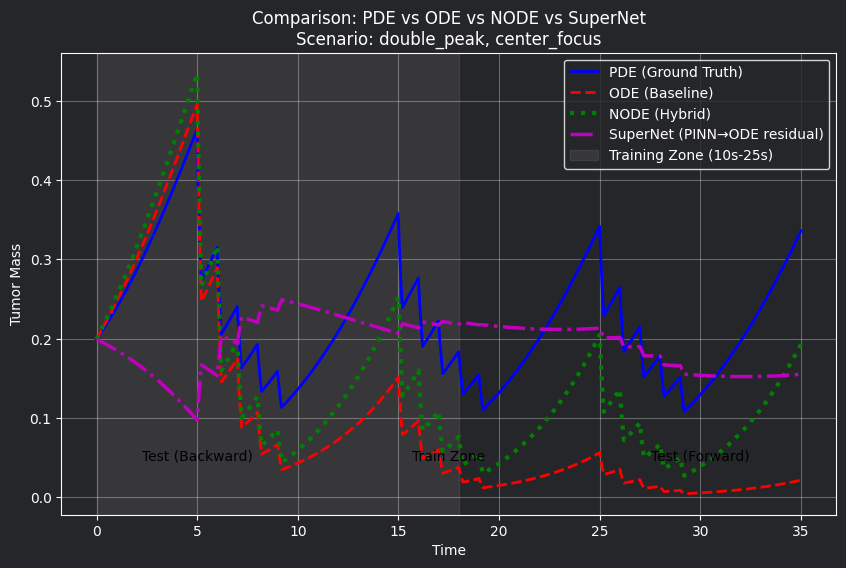

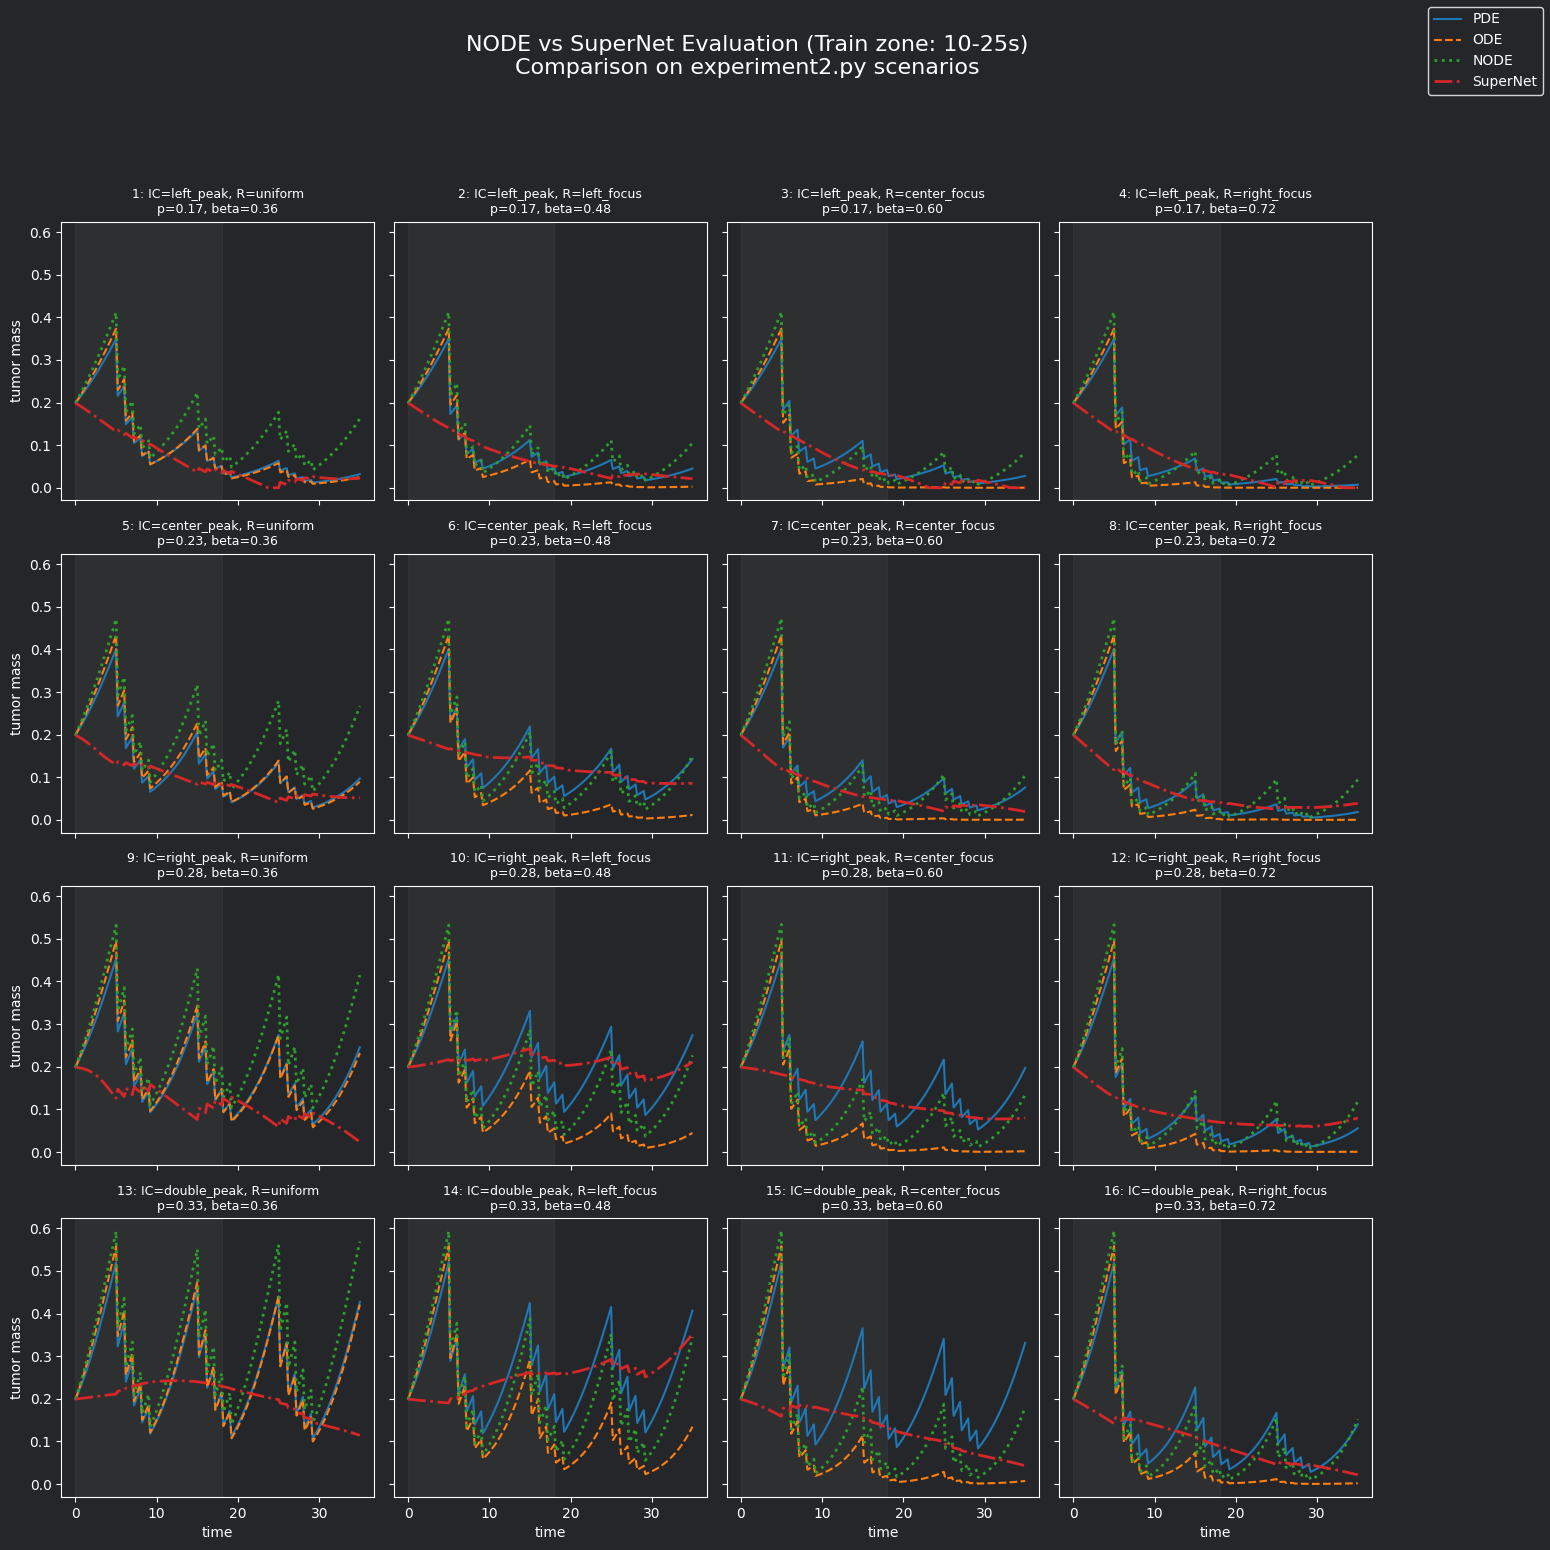

Gotowe. Wygenerowano pliki w: ../figures/sim_06


In [28]:
# ============================================================
# 9. Wizualizacja: PDE vs ODE vs NODE vs SuperNet (styl jak sim_04_node)
# ============================================================

def scenario_dict_from_names(ic_name: str, dose_name: str, rho_factor: float, beta_factor: float) -> tuple[dict, np.ndarray]:
    rho = float(rho_base * rho_factor)
    beta = float(beta_base * beta_factor)
    u0 = initial_condition(ic_name, x_grid).astype(np.float32)
    W = dose_profile(dose_name, x_grid).astype(np.float32)
    ts, m_pde = run_pde_simulation_full(D_base, rho, beta, u0, W, return_u_history=False)
    _, m_ode = run_pure_ode_simulation(u0, rho, beta, W)

    sc = {
        "ic_name": ic_name,
        "dose_name": dose_name,
        "rho": rho,
        "beta": beta,
        "u0": u0,
        "W": W,
        "ts": ts.astype(np.float32),
        "mass_pde": m_pde.astype(np.float32),
        "ic_params": ic_params(ic_name),
        "dose_params": dose_params(dose_name),
        "W_scale": compute_W_scale_np(dose_params(dose_name), x_grid),
    }
    sc["mass_pinn"] = predict_mass_series(pinn, sc, sc["ts"], x_grid).astype(np.float32)
    return sc, m_ode

# --- Single scenario plot ---
test_ic = "double_peak"
test_dose = "center_focus"
rho_factor = 1.1
beta_factor = 0.8

sc_test, m_ode = scenario_dict_from_names(test_ic, test_dose, rho_factor, beta_factor)

m_pde = sc_test["mass_pde"]
ts = sc_test["ts"]

m_node = run_node_simulation(node_model, sc_test)
m_super = run_supernet_simulation(supernet, sc_test)

plt.figure(figsize=(10, 6))
plt.plot(ts, m_pde, 'b-', linewidth=2, label='PDE (Ground Truth)')
plt.plot(ts, m_ode, 'r--', linewidth=2, label='ODE (Baseline)')
plt.plot(ts, m_node, 'g:', linewidth=3, label='NODE (Hybrid)')
plt.plot(ts, m_super, 'm-.', linewidth=2.5, label='SuperNet (PINN→ODE residual)')

plt.axvspan(T_TRAIN_START, T_TRAIN_END, color='gray', alpha=0.2, label='Training Zone (10s-25s)')

plt.text(5, max(m_pde)*0.1, "Test (Backward)", ha='center', color='black')
plt.text(17.5, max(m_pde)*0.1, "Train Zone", ha='center', color='black')
plt.text(30, max(m_pde)*0.1, "Test (Forward)", ha='center', color='black')

plt.xlabel("Time")
plt.ylabel("Tumor Mass")
plt.title(f"Comparison: PDE vs ODE vs NODE vs SuperNet\nScenario: {test_ic}, {test_dose}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(DEFAULT_OUTPUT_DIR / "sim06_supernet_comparison.png")
plt.show()

# --- Grid 4x4 plot ---
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)

scenario_idx = 0
for i, ic_name in enumerate(ic_kinds):
    for j, dose_name in enumerate(dose_kinds):
        scenario_idx += 1
        sc = scenarios[scenario_idx-1]
        ts = sc["ts"]
        m_pde = sc["mass_pde"]
        _, m_ode = run_pure_ode_simulation(sc["u0"], sc["rho"], sc["beta"], sc["W"])

        m_node = run_node_simulation(node_model, sc)
        m_super = run_supernet_simulation(supernet, sc)

        ax = axes[i, j]
        ax.plot(ts, m_pde, label="PDE")
        ax.plot(ts, m_ode, "--", label="ODE")
        ax.plot(ts, m_node, ":", linewidth=2, label="NODE")
        ax.plot(ts, m_super, "-.", linewidth=2, label="SuperNet")

        ax.axvspan(T_TRAIN_START, T_TRAIN_END, color='gray', alpha=0.1)

        ax.set_title(
            f"{scenario_idx}: IC={ic_name}, R={dose_name}\n"
            f"p={sc['rho']:.2f}, beta={sc['beta']:.2f}", fontsize=9
        )
        if i == 3:
            ax.set_xlabel("time")
        if j == 0:
            ax.set_ylabel("tumor mass")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.suptitle(
    "NODE vs SuperNet Evaluation (Train zone: 10-25s)\n"
    "Comparison on experiment2.py scenarios",
    fontsize=16
)

fig.tight_layout(rect=[0.03, 0.03, 0.9, 0.93])
plt.savefig(DEFAULT_OUTPUT_DIR / "sim06_supernet_grid.png")
plt.show()

print("Gotowe. Wygenerowano pliki w:", DEFAULT_OUTPUT_DIR)
